In [8]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [9]:
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns


Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [10]:
bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print bsize.columns


Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4778050350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f476dc4b710>]], dtype=object)

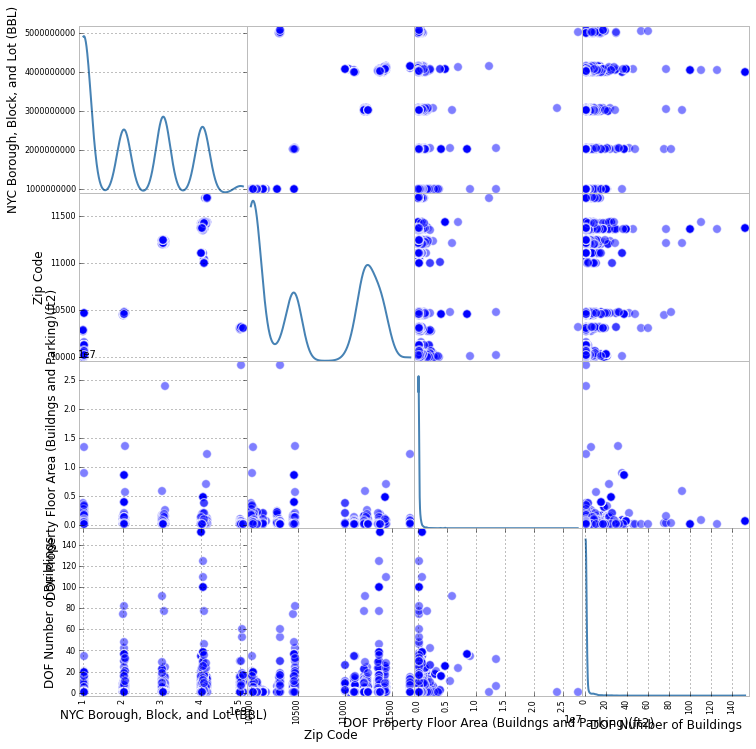

In [11]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(12, 12), diagonal='kde') #or diagonal=hist


it will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you gve t a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


In [12]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    
#vfunc = np.vectorize(canconvert)

Now for every column i care about i can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that 
I want to use from my arrays of interest. I can replace the entries that failed to be converted to 'NaN'

(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [14]:
#print nrg['Site EUI(kBtu/ft2)']
#has NaN values

In [16]:
#create the indeces array here
indx1 = np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)'])
indx2= np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)'])

print indx1, len(indx1)
print indx2, len(indx2)

[ True  True  True ...,  True  True  True] 16170
[ True  True  True ...,  True  True  True] 16170


In [18]:
nrg['Site EUI(kBtu/ft2)'][~indx1]=float('NaN')
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx2]=float('NaN')


/home/jannie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/jannie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [20]:
##check that your conversion worked: e.g.
print nrg['Site EUI(kBtu/ft2)'].astype(float)
print nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
print bsize.BBL.astype(float)
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

Record Number
16099      180.5
500         82.1
5017       137.7
5116       103.2
363         74.0
6876        36.4
10714      114.8
1214       130.0
1544       138.3
1905     56909.0
2301        88.2
15059       15.7
674          NaN
2537        85.7
2841       195.7
2945        79.1
15120      144.1
3053       200.9
4233       104.6
4777        86.7
4912       102.1
5210        21.2
5295        78.3
1575         NaN
15025       55.2
4208        83.2
4799       145.1
1568        59.4
5427        88.7
5476       100.8
          ...   
14559        NaN
14560        NaN
14748        NaN
14753        NaN
13582        NaN
13947        NaN
14777        NaN
14779        NaN
14409        NaN
13262        NaN
13261        NaN
12523        NaN
12529        NaN
12536        NaN
13929        NaN
13944        NaN
13945        NaN
13821        NaN
13829        NaN
13837        NaN
13838        NaN
13847        NaN
14352        NaN
12976        NaN
12978        NaN
12984        NaN
12987        NaN


#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [22]:
#merge the data
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
#print nrg.columns
bblnrgdata = pd.merge(nrg,bsize,how='inner', on=['BBL'])
print bblnrgdata.columns


Index([                  u'NYC Borough, Block, and Lot (BBL)',
                                    u'Co-reported BBL Status',
                                          u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
                                             u'Street Number',
                                               u'Street Name',
                                                 u'Borough_x',
                                                  u'Zip Code',
                        u'DOF Benchmarking Submission Status',
                                        u'Site EUI(kBtu/ft2)', 
       ...
                                                u'YearAlter2',
                                                 u'YearBuilt',
                                                    u'ZMCode',
                                                   u'ZipCode',
                                                 u'ZoneDist1',
                                           

once you have the dataframe with all the info you want, you want to plot 
Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

5344.0
3.50145188e+11


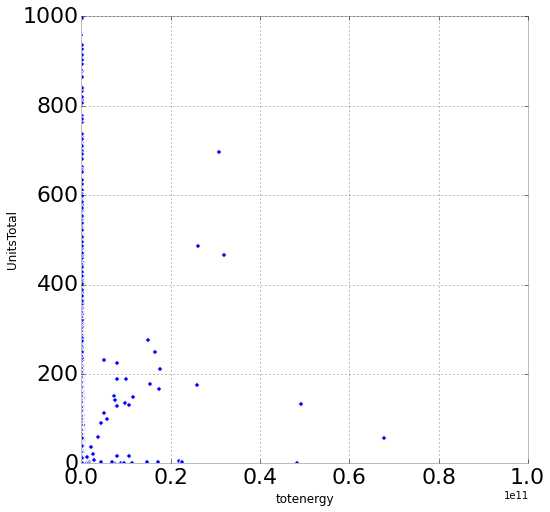

In [26]:
#Plotting
#I need to convert the df str into float to do math: .astype(float)
bblnrgdata['totenergy']= bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)*bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

print bblnrgdata.totenergy[bblnrgdata.totenergy>0].min()
print bblnrgdata.totenergy.max()

#I sum up total energy: Site EUI*area
#Use total units

#pl.plot(energy,unit, 'o')
#My original plotting setting: ax = bblnrgdata.plot('totenergy', 'UnitsTotal', kind='scatter', alpha=0.5)
bblnrgdata.plot(kind='scatter',x='totenergy',y='UnitsTotal', marker='o', figsize=(8, 8),  xlim=(1000,1e11), ylim=(1,1000), fontsize=22)


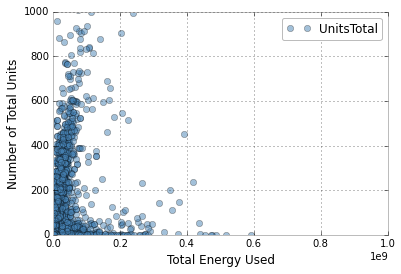

In [30]:
#zoomed in
ax = bblnrgdata.plot('totenergy', 'UnitsTotal', style='o', alpha=0.5)
ax.set_ylim(0,1000)
ax.set_xlim(1000,1e9)
ax.set_xlabel('Total Energy Used')
ax.set_ylabel('Number of Total Units')

when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


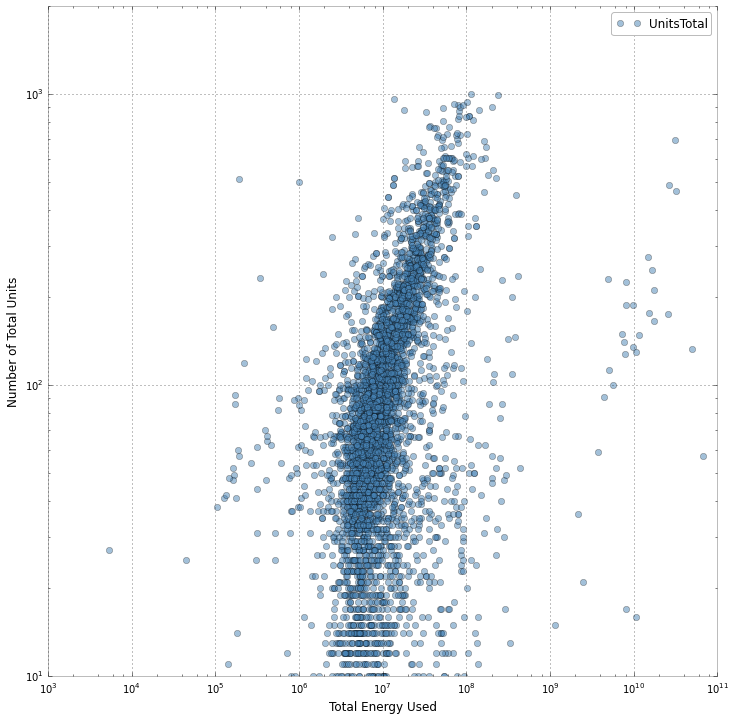

In [35]:
#my original input
#bblnrgdata_cut=bblnrgdata[(bblnrgdata.totenergy>1000) & (bblnrgdata.totenergy<1e10)][(bblnrgdata.UnitsTotal>10) & (bblnrgdata.UnitsTotal<1000)]

bblnrgdata_cut=bblnrgdata[(bblnrgdata.totenergy>1000) * (bblnrgdata.UnitsTotal>=10) * (bblnrgdata.UnitsTotal<1000)]

ax1=bblnrgdata_cut.plot('totenergy','UnitsTotal', style='o',loglog=True, alpha=0.5,xlim=(1000,1e11), ylim=(0,2000),figsize=(12, 12))
ax1.set_xlabel('Total Energy Used')
ax1.set_ylabel('Number of Total Units')
#solution plotting
#bblnrgdata_cut.plot(kind='scatter',x='totenergy',y='UnitsTotal', marker='o',  figsize=(16, 14), loglog=True, fontsize=20)

Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

if you used statsmodels it would look something like this:

Intercept    6.104499
x            0.490308
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     837.0
Date:                Tue, 20 Oct 2015   Prob (F-statistic):          3.70e-168
Time:                        17:05:10   Log-Likelihood:                -2541.4
No. Observations:                4253   AIC:                             5087.
Df Residuals:                    4251   BIC:                             5100.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------

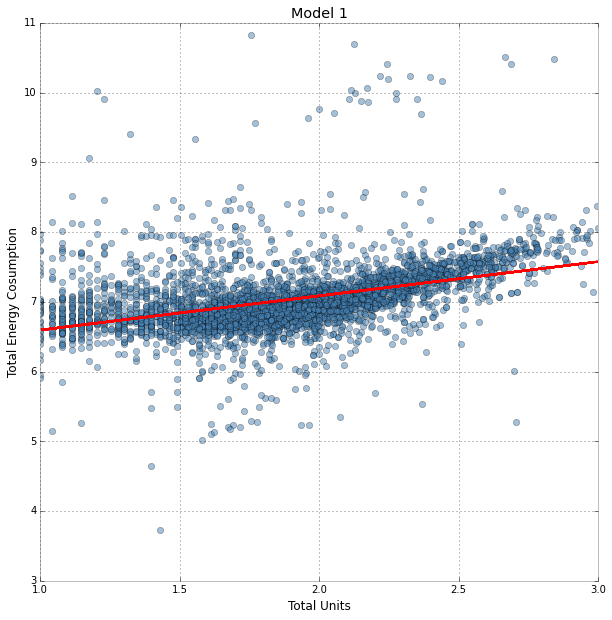

In [79]:
import statsmodels.api as sm
#from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf

#y: dependent variable
y = np.log10(bblnrgdata_cut.totenergy)
#x: independent variable
x = np.log10(bblnrgdata_cut.UnitsTotal)

model1 = smf.ols('y ~ x', data=bblnrgdata_cut, missing='drop').fit()
pl.figure(figsize=(10,10))
pl.plot(x, y, 'o',alpha=0.5)
plot(x,fit0.predict(),'r')
pl.title('Model 1')
pl.xlabel('Total Units')
pl.ylabel('Total Energy Cosumption')
print model1.params
print model1.summary()


remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


Intercept   -0.472310
y            0.335518
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     837.0
Date:                Tue, 20 Oct 2015   Prob (F-statistic):          3.70e-168
Time:                        15:05:29   Log-Likelihood:                -1734.7
No. Observations:                4253   AIC:                             3473.
Df Residuals:                    4251   BIC:                             3486.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------

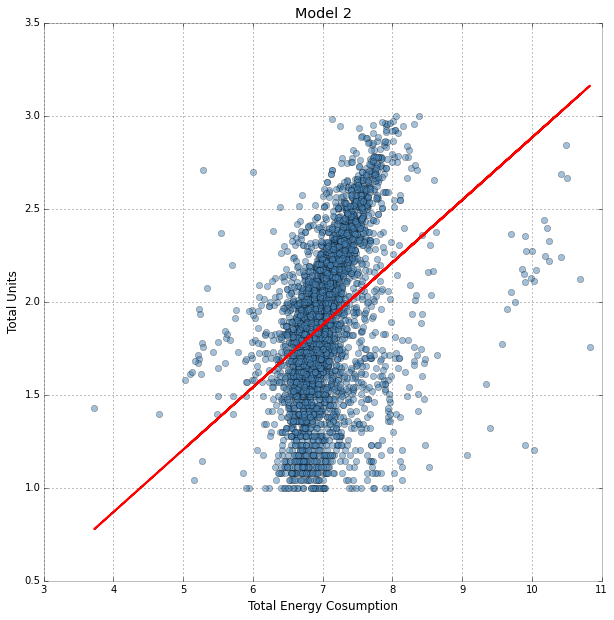

In [48]:
#Model 2
#fit and plots here

model2 = smf.ols('x ~ y', data=bblnrgdata_cut, missing='drop').fit()
pl.figure(figsize=(10,10))
pl.plot(y,x, 'o', alpha=0.5)
plot(y, model2.predict(),'r')
pl.title('Model 2')
pl.ylabel('Total Units')
pl.xlabel('Total Energy Cosumption')
print model2.params
print model2.summary()


##Second method: use statsmodels.api

                            OLS Regression Results                            
Dep. Variable:             UnitsTotal   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     837.0
Date:                Tue, 20 Oct 2015   Prob (F-statistic):          3.70e-168
Time:                        14:37:45   Log-Likelihood:                -1734.7
No. Observations:                4253   AIC:                             3473.
Df Residuals:                    4251   BIC:                             3486.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4723      0.082     -5.780      0.0

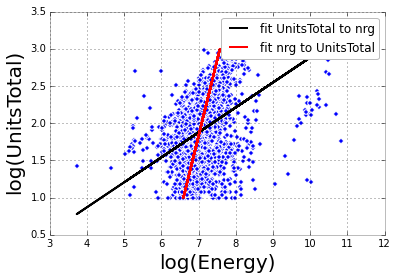

In [47]:
#second method: if use statsmodels.api
x1 = sm.add_constant(np.log10(bblnrgdata_cut.totenergy))
y1 = np.log10(bblnrgdata_cut.UnitsTotal)
model = sm.OLS(y1, x1, missing='drop').fit() # ignores entires where x or y is NaN
print model.summary()
print model.params[1], model.params[0], model # could also return stderr in each via fit.bse

pl.scatter(np.log10(bblnrgdata_cut.totenergy), np.log10(bblnrgdata_cut.UnitsTotal)) #pl.scatter(y1,x1)
plot(np.log10(bblnrgdata_cut.totenergy), model.predict(), 'k', label="fit UnitsTotal to nrg")

x0 = sm.add_constant(np.log10(bblnrgdata_cut.UnitsTotal))
y0 = np.log10(bblnrgdata_cut.totenergy)
model0 = sm.OLS(y0, x0, missing='drop').fit() # ignores entires where x or y is NaN
print model0.summary()
plot(model0.predict(), np.log10(bblnrgdata_cut.UnitsTotal), 'r', label="fit nrg to UnitsTotal")
pl.xlabel("log(Energy)", fontsize=20)
pl.ylabel("log(UnitsTotal)", fontsize=20)
pl.legend()

try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

###My Answer: 
The first model is better. First, it makes more sense if the total units is the independent, total energy is the dependent which means the total energy cosumpted is depend on how many units in the building.

The second model's coefficient is almost zero, which means y (total units) does not change a lot when x (total energy) changes.

I don't think we can use a liklihood ratio test here, because the likelihood test is performed by estimating two models and comparing the fit of one model to the fit of the other (e.g. a simple model and a more complicated model based on the simple model). The two models need to be nested so removing predictor variables from a model will almost always make the model fit less well (i.e., a model will have a lower log likelihood). Here we simply just change the indenpedent and depedent, these two models are non-nested (they have the same degree of freedom).


###ANSWER From solution:
the fit that uses number of Units as independent variable is clearly better. That is because the UnitsTotals data spans the range of values more uniformly than the nrg variable.

The fact that the fit is better can be seen by a larger likelihood, however a likelihood test CANNOT be performed. I see 2 reasons for that:

1) technical: the likelihood range requires the difference in the degrees of freedom between the variables to be >1 in order to compare its result with the chi square distribution

2) intellectual: we want to only compare regressions on the same variable!

##now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fit by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

[ 0.57599122 -1.6990692   8.09360888]


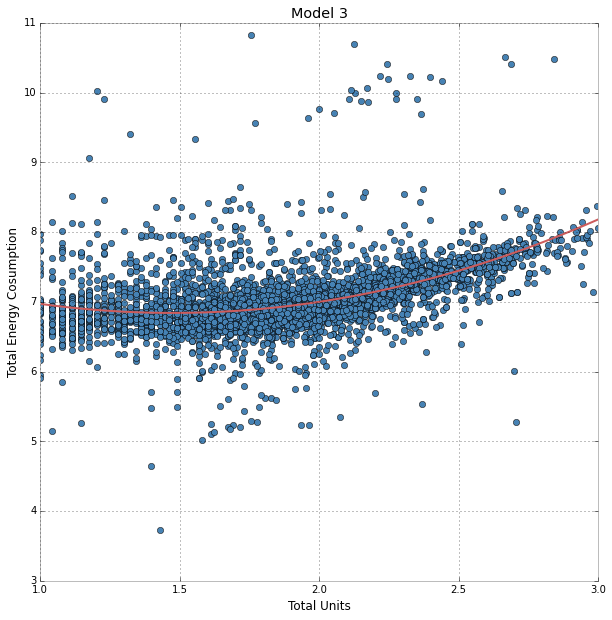

In [53]:
#Model 3 method 1
x3 = np.log10(bblnrgdata_cut.UnitsTotal)
y3 = np.log10(bblnrgdata_cut.totenergy)

z = np.polyfit(x3, y3, 2)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(x3.min(), x3.max(), 100)
y_new = f(x_new)
pl.figure(figsize=(10,10))
pl.plot(x3,y3,'o', x_new, y_new)
pl.xlabel('Total Units')
pl.ylabel('Total Energy Cosumption')
pl.title('Model 3')

print z
#np.polyfit returns Polynomial coefficients.

###some reference for 1st, 2nd, 3rd order polynomial:
http://www.datarobot.com/blog/multiple-regression-using-statsmodels/

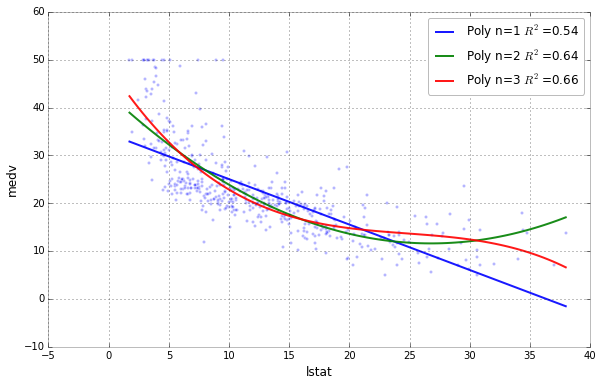

In [68]:
#Example from above reference

# load the boston housing dataset - median house values in the Boston area
df = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/MASS/Boston.csv')

# plot lstat (% lower status of the population) against median value
plt.figure(figsize=(6 * 1.618, 6))
plt.scatter(df.lstat, df.medv, s=10, alpha=0.3)
plt.xlabel('lstat')
plt.ylabel('medv')

# points linearlyd space on lstats
x = pd.DataFrame({'lstat': np.linspace(df.lstat.min(), df.lstat.max(), 100)})

# 1-st order polynomial
poly_1 = smf.ols(formula='medv ~ 1 + lstat', data=df).fit()
plt.plot(x.lstat, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, 
         alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='medv ~ 1 + lstat + I(lstat ** 2.0)', data=df).fit()
plt.plot(x.lstat, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='medv ~ 1 + lstat + I(lstat ** 2.0) + I(lstat ** 3.0)', data=df).fit()
plt.plot(x.lstat, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

plt.legend()

#print poly_1.summary()
#print poly_2.summary()
#print poly_3.summary()

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     629.1
Date:                Tue, 20 Oct 2015   Prob (F-statistic):          4.69e-240
Time:                        17:07:16   Log-Likelihood:                -2372.2
No. Observations:                4253   AIC:                             4750.
Df Residuals:                    4250   BIC:                             4769.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        8.0936      0.111     73.208   

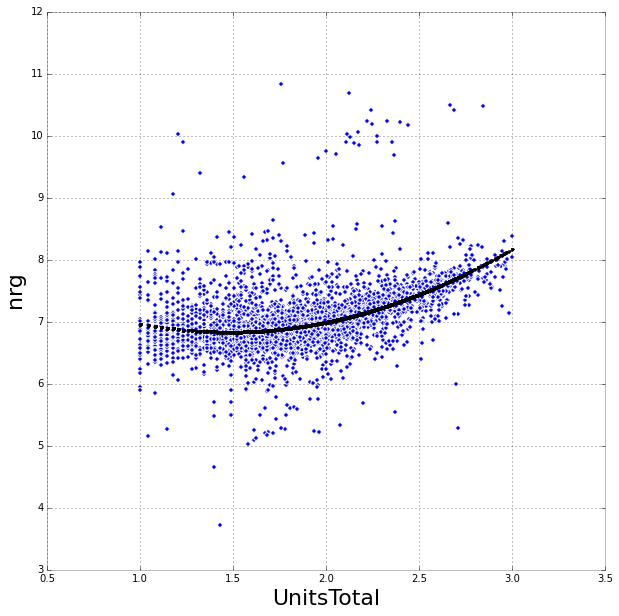

In [83]:
#Model 3 method 2
#my method: correct
#x3 = np.log10(bblnrgdata_cut.UnitsTotal)
#y3 = np.log10(bblnrgdata_cut.totenergy)
#model_sd = smf.ols('y3 ~ 1+x3+I(x3**2.0)', data=bblnrgdata_cut.totenergy).fit()
#pl.scatter(x3, y3)
#x= pd.DataFrame({'UnitsTotal_log': np.linspace(x3.min(), x3.max(), 100)})
#print model_sd.summary()
#plot(x3,model_sd.predict(),'k.')

curvemodel = smf.ols(formula = "y3 ~ x3 + I((x3)) + I((x3)**2) ", 
        data={'x3':np.log10(bblnrgdata_cut.UnitsTotal),'y3': np.log10(bblnrgdata_cut.totenergy)}).fit()
print curvemodel.summary()

pl.figure(figsize=(10, 10))
pl.scatter(np.log10(bblnrgdata_cut.UnitsTotal), np.log10(bblnrgdata_cut.totenergy))
pl.xlabel("UnitsTotal", fontsize=22)
pl.ylabel("nrg", fontsize=22)
plot(np.log10(bblnrgdata_cut.UnitsTotal), curvemodel.predict(), 'k.')


##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??
###Answer:
A liklihood ratio test can be used to test these two models because they are nested with different degree of freedom.

Compare with Model 1, Model 3 is better because it has a higher adj. R-squared value. 

###(Note that log-likelihood and R-squared along itself does not mean the third model is better than the first model)

HERE IS MORE READING ON LIKELIHOOD RATIO TEST:
https://evomics.org/resources/likelihood-ratio-test/

The likelihood ratio test (LRT) is a statistical test of the goodness-of-fit between two models. A relatively more complex model is compared to a simpler model to see if it fits a particular dataset significantly better.
######------------------------------------------------------------------------------


In [91]:
#do a likelihood test
print curvemodel.compare_lr_test(model1)
#print '%.2f' % curvemodel.compare_lr_test(model1)[1]


#I want to convince myself of what it actually means, so I calculate it by hand
#The LRT begins with a comparison of the likelihood scores of the two models:
#LR = 2*(lnL1-lnL2)

#the p-value is the second number returned by statsmodels.ols compare_lr_test 

print "LR : ", -2 * (-model1.llf - (-curvemodel.llf))

(338.52115982232226, 1.3394845683215865e-75, 1.0)
LR :  -338.521159822


###Professor's note: 
the null model (the simple one) is at the numerator. since the likelihood is bound to increaase with a lerger number of degrees of freedom that loglikelihood will be smaller, and its negative will be larger (sorry it gets tricky with signs here...not my fault -loglikelihood is what you want!)

difference in parameters = chi2 DOF = 1

the critical value for chi2 with 1 degree of freedom at alpha = 0.05 is 3.84

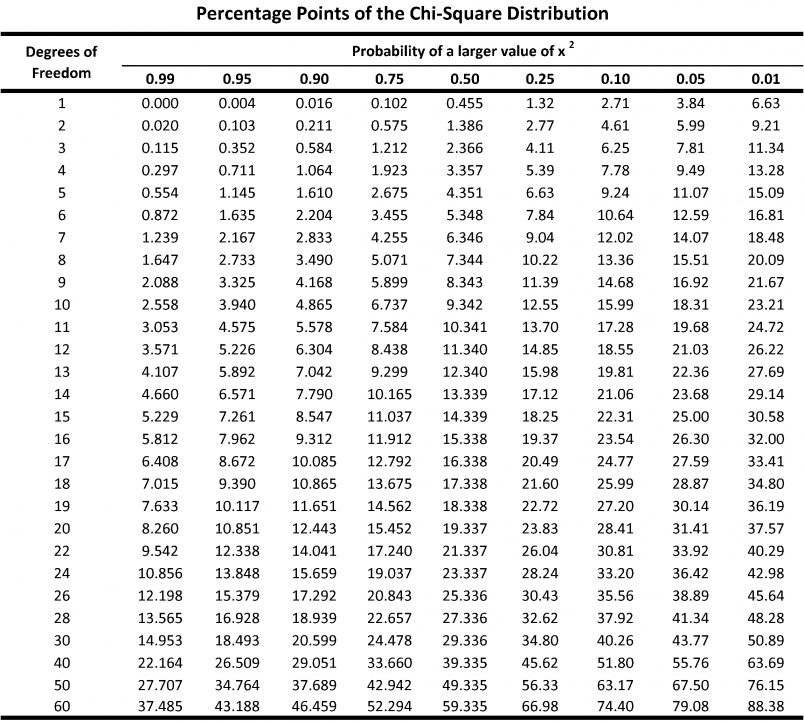

In [92]:
from IPython.display import Image
Image("http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG")

this likelihood ratio is a really really large number! indicating my curve fit is definitely better then my linear fit

Formally: H0: line fit is better then 2 deg polynomial fit H1: line fit is worse than the 2 deg polynomial fit

DEGREES OF FREEDOM: 1 (the curve fit has 1 extra parameter, so 1 more degree of freedom compared to the line fit)

the chisq value for a 1 degree of freedom chisq distribution at apha = 0.05 is 3.84

the probability of our D is far smaller then 0.05, so we can comfortably reject the Null that the line is a better fit
this implies that a 2 parameter model is BETTER, and the addition of the parameters is justified: we are NOT overfitting our data

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

###See professor's solution for extra credits!

https://github.com/fedhere/PUI2015_fbianco/blob/master/HW5/solutions/building_nrg_solution.ipynb

In [97]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

##WLS: See Heteroscedasticity:
https://en.wikipedia.org/wiki/Heteroscedasticity

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




0.0 85.0


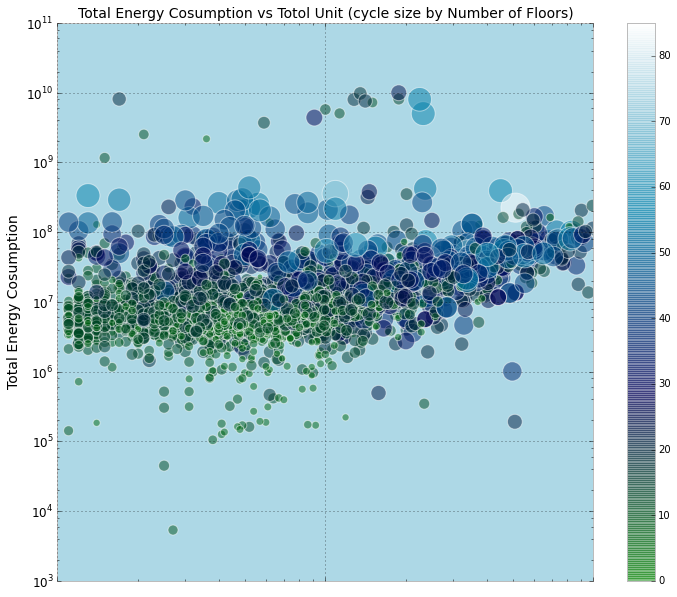

In [122]:
#Ocean like plot
print bblnrgdata_cut['NumFloors'].min(), bblnrgdata_cut['NumFloors'].max()

ax=bblnrgdata_cut.plot(kind='scatter',x='UnitsTotal',y='totenergy', fontsize=12, colormap='ocean', alpha = 0.5, marker='o',  figsize=(12, 10), loglog=True,  xlim=(10,1000), ylim=(1000,1e11), c=bblnrgdata_cut['NumFloors'], s=bblnrgdata_cut['NumFloors']*10)
ax.set_axis_bgcolor('lightblue')
pl.xlabel('Total Unit', size=14)
pl.ylabel('Total Energy Cosumption', size=14)
pl.title('Total Energy Cosumption vs Totol Unit (cycle size by Number of Floors)', fontsize=14)